In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams['figure.figsize'] = [16, 72]

In [4]:
#Opening the experiment json
def load_probe_metric_list(fname):
    with open(fname,"r") as rhandle:
        probe_metric_list = json.load(rhandle)
    
    #Converting the metric into usable format
    pdict = defaultdict(list)
    for idx in range(len(probe_metric_list)):
        pdict["angle:m-t0"].append(probe_metric_list[idx]["conv_angle_dict"]["main"]["topic0"])
        pdict["angle:m-t1"].append(probe_metric_list[idx]["conv_angle_dict"]["main"]["topic1"])
        pdict["angle:t0-t1"].append(probe_metric_list[idx]["conv_angle_dict"]["topic0"]["topic1"])
        if "w_sp" in probe_metric_list[idx]["conv_angle_dict"]:
            pdict["w_sp/w_inv"].append(probe_metric_list[idx]["conv_angle_dict"]["w_sp"]["w_inv"])
        pdict["acc:main"].append(probe_metric_list[idx]["classifier_acc_dict"]["main"])
        pdict["acc:topic0"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0"])
        pdict["topic0_main"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main"])
        pdict["topic0_pdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main_pdelta"])
        pdict["acc:topic1"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1"])
        pdict["topic1_main"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main"])
        pdict["topic1_pdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main_pdelta"])
        if "topic1_flip_emb_diff" in probe_metric_list[idx]["classifier_acc_dict"]:
            pdict["topic1_emb_diff"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_emb_diff"])
            pdict["topic0_emb_diff"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_emb_diff"])
        if "topic1_flip_main_logpdelta" in probe_metric_list[idx]["classifier_acc_dict"]:
            pdict["topic0_logpdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic0_flip_main_logpdelta"])
            pdict["topic1_logpdelta"].append(probe_metric_list[idx]["classifier_acc_dict"]["topic1_flip_main_logpdelta"])
    return pdict

In [3]:
#Collecting multiple runs of experiment
def aggregate_random_runs(rdict_list):
    '''
    '''
    rdict_agg_list = defaultdict(list)
    for rdict in rdict_list:
        for key,val in rdict.items():
            rdict_agg_list[key]+=val
    
    #Now taking the mean of the experiments
    rdict_agg = defaultdict(list)
    for key,val in rdict_agg_list.items():
        rdict_agg[key] = dict(
                            mean = np.mean(val),
                            std  = np.std(val)
        )
    
    return rdict_agg

def get_all_result_dict(run_list,pval_list,fname_pattern):
    all_result_dict = {}
    for pidx,pval in enumerate(pval_list):
        prdict_list = []
        for nidx in run_list:
            fname = fname_pattern.format(pval,nidx)
            prdict = load_probe_metric_list(fname)
            prdict_list.append(prdict)
        #Getting the aggregate result
        prdict_agg = aggregate_random_runs(prdict_list)
        all_result_dict[pval] = prdict_agg

    return all_result_dict

def plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=""):
    '''
    '''
    #Now we can reuse the previous ax
    if(type(ax)!=type(np.array([1,2]))):
        fig,ax = plt.subplots(len(plot_item_list),)
        
    for iidx,item_name in enumerate(plot_item_list):
        #Colletcing the metrics
        yval = [all_result_dict[pval][item_name]["mean"] for pval in pval_list]
        yerr = [all_result_dict[pval][item_name]["std"] for pval in pval_list]
        #Plotting the guy
        ax[iidx].errorbar(pval_list,yval,yerr,ls="-.",marker="o",label=item_name+extra_label)
#         ax[iidx].set_ylim(0.0,1.0)
        ax[iidx].set_xlabel("correlation value [0.5,1]")
        ax[iidx].set_ylabel("value")
        ax[iidx].legend()
        ax[iidx].grid(True)
        ax[iidx].set_title(item_name)
    return ax

# Variation with sample size

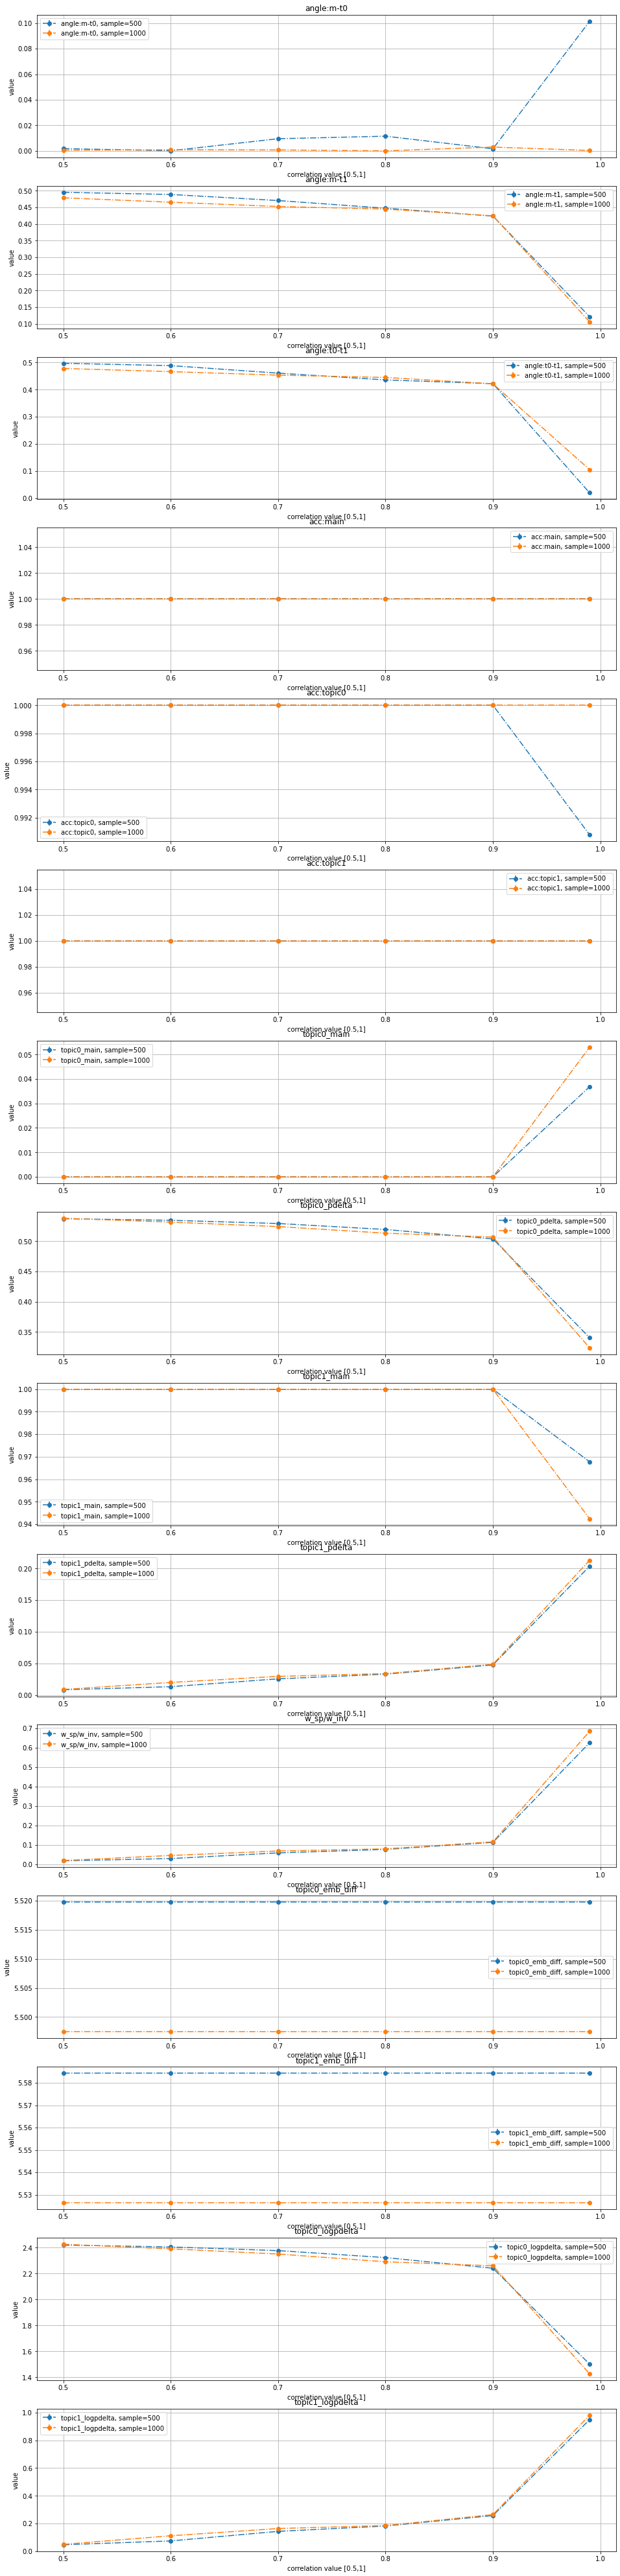

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [14]:
#Getting the result for different epochs
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "w_sp/w_inv",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
loss_type="linear_svm"
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
s=500
e=15
l2=0.1
dtype="tabular"
inv_dims=1
h=0
for s in [500,1000]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.dtype({}).invdims({}).lt({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  dtype,
                                                                                  inv_dims,
                                                                                  loss_type,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", sample={}".format(s))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

# Testing the variation with the regularization

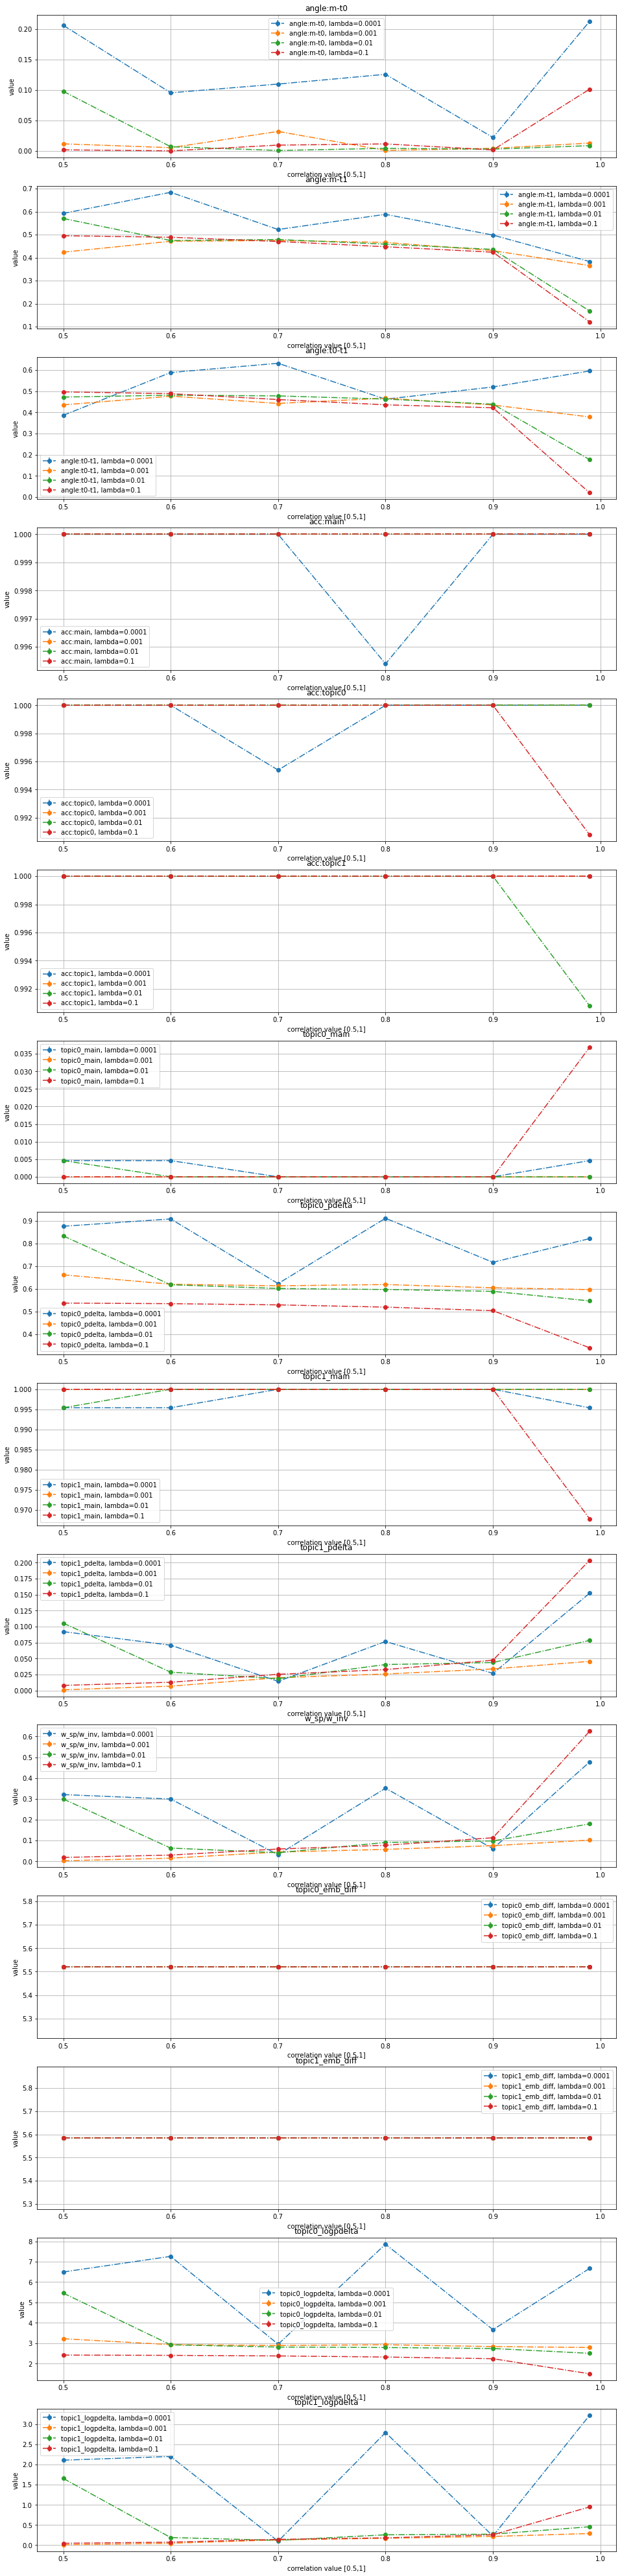

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [18]:
#Getting the result for different epochs
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "w_sp/w_inv",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
loss_type="linear_svm"
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
s=500
e=15
l2=0.1
dtype="tabular"
inv_dims=1
h=0
for l2 in ["0.0001","0.001","0.01","0.1"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.dtype({}).invdims({}).lt({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  dtype,
                                                                                  inv_dims,
                                                                                  loss_type,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", lambda={}".format(l2))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

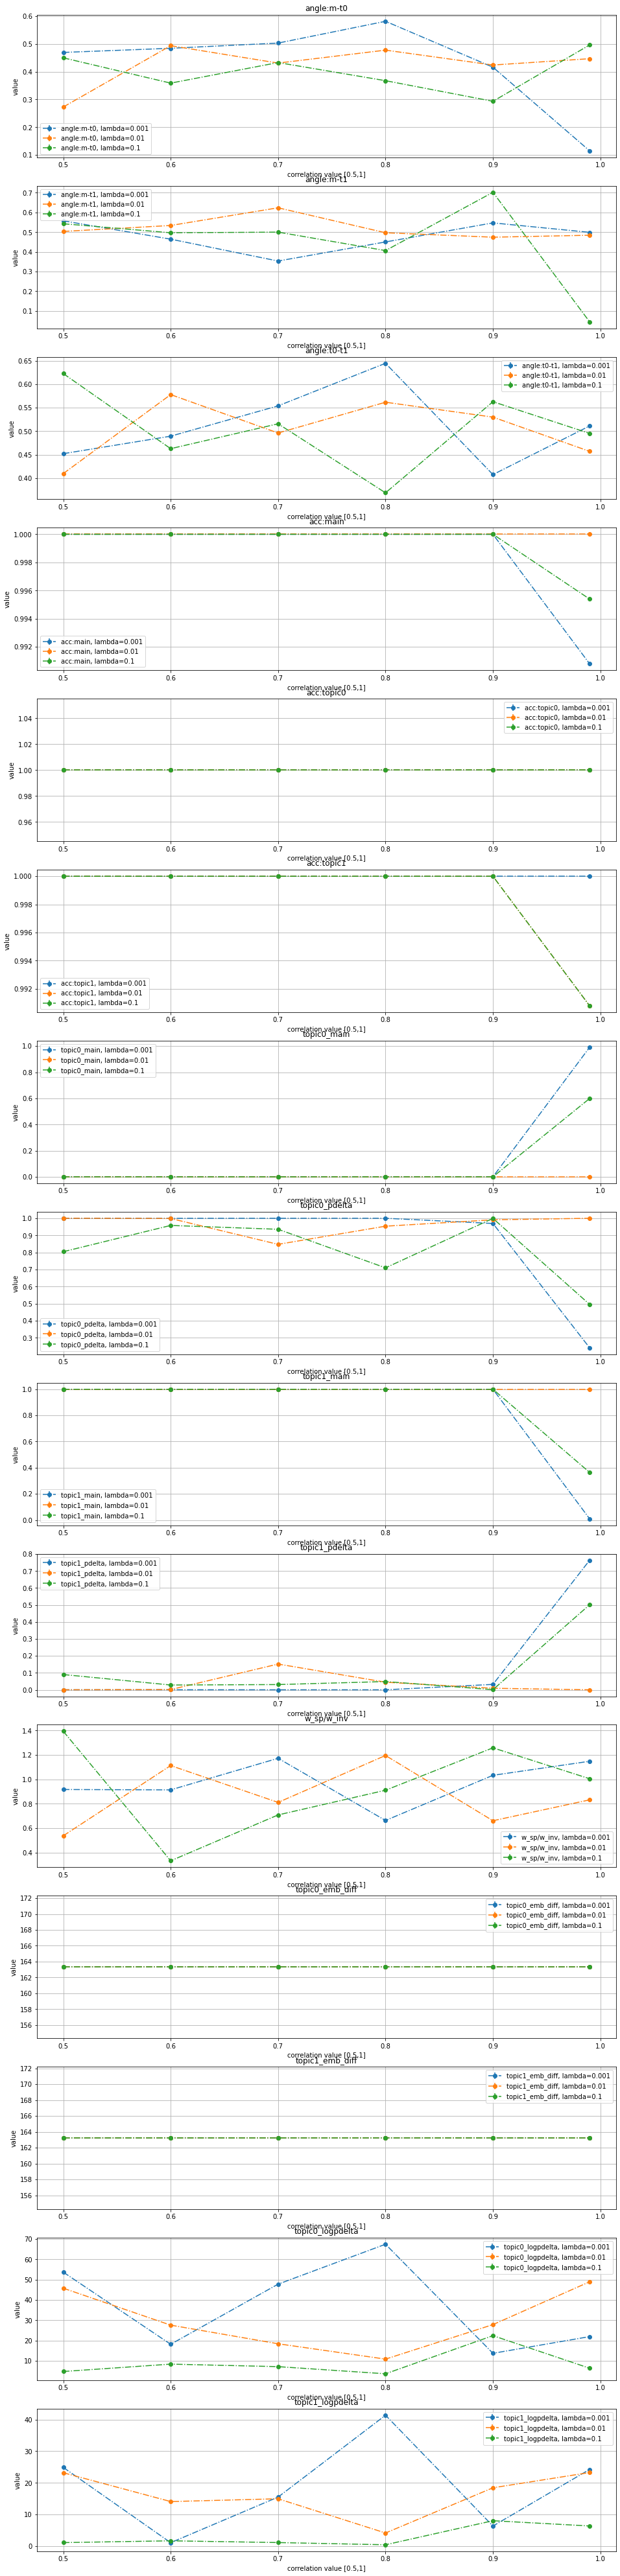

'\nHere we should choose h and lambda combination which is best for the model and see the trend.\n'

In [20]:
#Getting the result for different epochs
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "w_sp/w_inv",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
loss_type="linear_svm"
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
s=500
e=15
l2=0.1
dtype="tabular"
inv_dims=10
h=0
for l2 in ["0.001","0.01","0.1"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.dtype({}).invdims({}).lt({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  dtype,
                                                                                  inv_dims,
                                                                                  loss_type,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", lambda={}".format(l2))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''

In [ ]:
#Getting the result for different epochs
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99,]
plot_item_list = [
                    "angle:m-t0",
                    "angle:m-t1",
                    "angle:t0-t1",
                    "acc:main",
                    "acc:topic0",
                    "acc:topic1",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic1_main",
                    "topic1_pdelta",
                    "w_sp/w_inv",
                    "topic0_emb_diff",
                    "topic1_emb_diff",
                    "topic0_logpdelta",
                    "topic1_logpdelta",
]


ax=None

#Other hyperparam
loss_type="linear_svm"
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
s=500
e=15
l2=0.1
dtype="tabular"
inv_dims=100
h=0
for l2 in ["0.0","0.00001","0.0001","0.001","0.01","0.1"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          fname_pattern="nlp_logs/pt.rel.dtype({}).invdims({}).lt({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  dtype,
                                                                                  inv_dims,
                                                                                  loss_type,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", lambda={}".format(l2))


plt.show()
'''
Here we should choose h and lambda combination which is best for the model and see the trend.
'''